In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
from __future__ import print_function
import numpy as np
import pandas as pd
import sys
import os
import io
import tensorflow as tf
print(tf.__version__)
import codecs
from keras.callbacks import LambdaCallback, ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM, Bidirectional
from keras.models import load_model
from keras.layers import BatchNormalization
from keras.optimizers import RMSprop
from tensorflow.keras.utils import plot_model

2.4.1


In [3]:
sequence_length=10
min_word_frequency=50
step=1
batch_size=12

**Shuffle and split training set**

In [4]:
def shuffle_and_split_training_set(sentences_original, next_original, percentage_test=2):
  print("Shuffling sentences...")
  tmp_sentences=[]
  tmp_next_word=[]
  for i in np.random.permutation(len(sentences_original)):
    tmp_sentences.append(sentences_original[i])
    tmp_next_word.append(next_original[i])
  cut_index=int((1-((percentage_test)/100.0))*len(sentences_original))
  x_train, x_test=tmp_sentences[:cut_index], tmp_sentences[cut_index:]
  y_train, y_test=tmp_next_word[:cut_index], tmp_next_word[cut_index:]
  print("Size of training set=", len(x_train))
  print("Size of test set=", len(y_test))
  return (x_train, x_test), (y_train, y_test)

**Generator function**

In [5]:
def generator(sentence_list, next_word_list, batch_size):
  index=0
  while True:
    x=np.zeros((batch_size, sequence_length, len(words)), dtype=np.bool)
    y=np.zeros((batch_size, len(words)), dtype=np.bool)
    for i in range(batch_size):
      for t, w in enumerate(sentence_list[index%len(sentence_list)]):
        x[i, t, word_indices[w]]=1
      y[i, word_indices[next_word_list[index%len(sentence_list)]]]=1
      index+=1
    yield x, y

**Write generated vocabulary to a file**

In [6]:
def print_vocabulary(words_file_path, words_set):
  words_file=codecs.open(words_file_path, 'w', encoding='utf8')
  for w in words_set:
    if (w!='\n'):
      words_file.write(w+"\n")
    else:
      words_file.write(w)
  words_file.close()

**Build an LSTM Model**

In [7]:
def get_model(dropout=0.2):
    print('Build model...')
    model=tf.keras.Sequential()
    model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(sequence_length, len(words))))
    model.add(BatchNormalization())
    model.add(Activation('selu'))
    if dropout>0:
      model.add(Dropout(dropout))
    
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Activation('selu'))
    if dropout>0:
      model.add(Dropout(dropout))
    
    model.add(Bidirectional(LSTM(256, return_sequences=True)))
    model.add(BatchNormalization())
    model.add(Activation('selu'))
    if dropout>0:
      model.add(Dropout(dropout))
    
    model.add(Bidirectional(LSTM(512)))
    if dropout > 0:
        model.add(Dropout(dropout))
    model.add(Dense(len(words)))
    model.add(Activation('softmax'))
    print("Done!")
    return model
'''def get_model(dropout=0.2):
    print('Build model...')
    model=tf.keras.Sequential()
    model.add(Bidirectional(LSTM(len(words)*7, return_sequences=True), input_shape=(sequence_length, len(words))))
    model.add(BatchNormalisation())
    model.add(Activation('selu'))
    if dropout>0:
      model.add(Dropout(dropout))
    
    model.add(Dense(len(words)*4))
    model.add(Activation('selu'))
    if dropout>0:
      model.add(Dropout(dropout))
    
    model.add(Dense(len(words)*4))
    model.add(BatchNormalisation())
    model.add(Activation('selu'))
    if dropout>0:
      model.add(Dropout(dropout))
      
    model.add(Dense(len(words)))
    model.add(Activation('softmax'))
    print("Done!")
    return model'''

'def get_model(dropout=0.2):\n    print(\'Build model...\')\n    model=tf.keras.Sequential()\n    model.add(Bidirectional(LSTM(len(words)*7, return_sequences=True), input_shape=(sequence_length, len(words))))\n    model.add(BatchNormalisation())\n    model.add(Activation(\'selu\'))\n    if dropout>0:\n      model.add(Dropout(dropout))\n    \n    model.add(Dense(len(words)*4))\n    model.add(Activation(\'selu\'))\n    if dropout>0:\n      model.add(Dropout(dropout))\n    \n    model.add(Dense(len(words)*4))\n    model.add(BatchNormalisation())\n    model.add(Activation(\'selu\'))\n    if dropout>0:\n      model.add(Dropout(dropout))\n      \n    model.add(Dense(len(words)))\n    model.add(Activation(\'softmax\'))\n    print("Done!")\n    return model'

In [8]:
def sample(preds, temperature=1.0):
  preds=np.asarray(preds).astype('float64')
  preds=np.log(preds)/temperature
  exp_preds=np.exp(preds)
  preds=exp_preds/sum(exp_preds)
  probas=np.random.multinomial(1, preds, 1)
  return np.argmax(probas)

**Behavior at the end of an epoch**

In [9]:
def on_epoch_end(epoch, logs):
  examples_file.write("\n---Generating text after epoch %d\n"%epoch)
  seed_index=np.random.randint(len(sentences_train+sentences_test))
  seed=(sentences_train+sentences_test)[seed_index]
  diversity_array=np.arange(0.3, 0.8, 0.1)
  for diversity in diversity_array:
    sentence=seed
    diversity_string="\n---Diversity=%s.\n"%str(diversity)
    joined=' '.join(sentence)
    seed_sentence="\n---Seed sentence:%s.\n"%joined
    examples_file.write(diversity_string)
    examples_file.write(seed_sentence)
    examples_file.write(joined)
    examples_file.write('\n')
    for i in range(50):
      x_pred=np.zeros((1, sequence_length, len(words)))
      for t, word in enumerate(sentence):
        x_pred[0, t, word_indices[word]]=1
      preds=model.predict(x_pred, verbose=1)[0]
      next_index=sample(preds, diversity)
      next_word=indices_word[next_index]
      sentence=sentence[1:]
      sentence.append(next_word)
    examples_file.write(" "+next_word)
  examples_file.write("\n")
  examples_file.flush()

**Laurell K. Hamilton**

In [10]:
corpus='/content/gdrive/MyDrive/Project folder/Author text files/Laurell K. Hamilton.txt'
examples='/content/gdrive/MyDrive/Project folder/Authorwise examples/examples_laurell_k_hamilton.txt'
vocabulary='/content/gdrive/MyDrive/Project folder/Authorwise vocabulary/vocabulary_laurell_k_hamilton.txt'

In [11]:
if not os.path.isdir('/content/gdrive/MyDrive/Project folder/Authorwise text generation/Laurell K. Hamilton/checkpoints'):
  os.makedirs('/content/gdrive/MyDrive/Project folder/Authorwise text generation/Laurell K. Hamilton/checkpoints')

In [12]:
#with io.open(corpus, encoding='utf-8') as file:
file=open(corpus, encoding='utf8')
text=file.read().lower().replace('\n', '\n ')
print('Corpus length in characters=', len(text))

Corpus length in characters= 20199014


In [13]:
text_in_words=[w for w in text.split(' ') if w.strip()!='' or w=='\n']
print("Corpus length in words=", len(text_in_words))

Corpus length in words= 3799888


In [14]:
word_freq={}
for word in text_in_words:
  word_freq[word]=1+word_freq.get(word, 0)

In [15]:
len(word_freq)

94265

In [16]:
ignored_words=set('\n')
for k, v in word_freq.items():
  if word_freq[k]<min_word_frequency:
    ignored_words.add(k)

In [17]:
words=set(text_in_words)
print("Unique words before ignoring:", len(words))
words=sorted(set(text_in_words)-ignored_words)
print("Unique words after ignoring:", len(words))
print_vocabulary(vocabulary, words)

Unique words before ignoring: 94265
Unique words after ignoring: 5147


In [18]:
word_indices=dict((c, i) for i, c in enumerate(words))
indices_word=dict((i, c) for i, c in enumerate(words))

In [19]:
sentences=[]
next_words=[]
ignored=0
print("Generating sequences...", end="")
for i in range(0, len(text_in_words)-sequence_length, step):
  if (len(set(text_in_words[i:i+sequence_length+1]).intersection(ignored_words))==0):
    sentences.append(text_in_words[i:i+sequence_length])
    next_words.append(text_in_words[i+sequence_length])
  else:
    ignored+=1
print("Done!")

Generating sequences...Done!


In [20]:
print("Total ignored sequences: ", ignored)
print("Remaning sentences: ", len(sentences))
print("Number of words: ", len(next_words))

Total ignored sequences:  2636225
Remaning sentences:  1163653
Number of words:  1163653


In [21]:
(sentences_train, sentences_test), (next_words_train, next_words_test)=shuffle_and_split_training_set(sentences, next_words)

Shuffling sentences...
Size of training set= 1140379
Size of test set= 23274


In [22]:
model=get_model()

Build model...
Done!


In [23]:
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(learning_rate=0.01), metrics=['accuracy'])

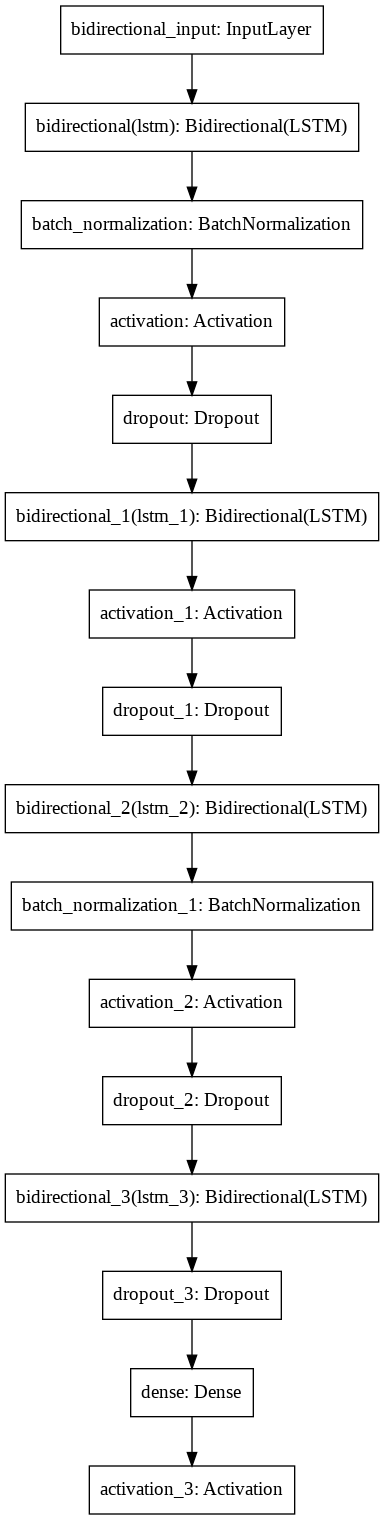

In [24]:
plot_model(model, to_file='Laurell K. Hamilton Model.png')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 10, 256)           5402624   
_________________________________________________________________
batch_normalization (BatchNo (None, 10, 256)           1024      
_________________________________________________________________
activation (Activation)      (None, 10, 256)           0         
_________________________________________________________________
dropout (Dropout)            (None, 10, 256)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 10, 256)           394240    
_________________________________________________________________
activation_1 (Activation)    (None, 10, 256)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 256)           0

In [ ]:
examples_file=open(examples, "w")

In [ ]:
file_path = "//content/gdrive/MyDrive/Project folder/Authorwise text generation/Laurell K. Hamilton/checkpoints/METG-epoch{epoch:03d}-words%d-sequence%d-minfreq%d-" \
                "loss{loss:.4f}-accuracy{accuracy:.4f}-val_loss{val_loss:.4f}-val_accuracy{val_accuracy:.4f}" % \
                (len(words), sequence_length, min_word_frequency)

In [ ]:
checkpoint=ModelCheckpoint(file_path, monitor='val_accuracy', save_best_only=True)
print_callback=LambdaCallback(on_epoch_end=on_epoch_end)
early_stopping=EarlyStopping(monitor='val_accuracy', patience=1)
callbacks_list=[checkpoint, print_callback, early_stopping]

In [ ]:
with tf.device('/gpu:0'):
  model.fit_generator(generator(sentences_train, next_words_train, batch_size), 
                    steps_per_epoch=int(len(sentences_train)/batch_size)+1, 
                    epochs=12, 
                    callbacks=callbacks_list, 
                    validation_data=generator(sentences_test, next_words_test, batch_size), 
                    validation_steps=int(len(sentences_test)/batch_size)+1)
from keras.models import model_from_json
model_json=model.to_json()
with open("/content/gdrive/MyDrive/Project folder/Authorwise text generation/Laurell K. Hamilton/model_laurell_k_hamilton.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("/content/gdrive/MyDrive/Project folder/Authorwise text generation/Laurell K. Hamilton/laurell_k_hamilton.h5")
print("Saved model to disk!")

Epoch 1/12


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


95032/95032 [==============================] - 6224s 65ms/step - loss: 13.5681 - accuracy: 0.0140 - val_loss: 17.3585 - val_accuracy: 0.0051


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Laurell K. Hamilton/checkpoints/METG-epoch001-words5147-sequence10-minfreq50-loss16.1244-accuracy0.0123-val_loss17.3585-val_accuracy0.0051/assets


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Laurell K. Hamilton/checkpoints/METG-epoch001-words5147-sequence10-minfreq50-loss16.1244-accuracy0.0123-val_loss17.3585-val_accuracy0.0051/assets


1/1 [==============================] - 0s 31ms/step
Epoch 2/12
95032/95032 [==============================] - 6263s 66ms/step - loss: 21.5464 - accuracy: 0.0120 - val_loss: 22.3079 - val_accuracy: 0.0137


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Laurell K. Hamilton/checkpoints/METG-epoch002-words5147-sequence10-minfreq50-loss22.4103-accuracy0.0119-val_loss22.3079-val_accuracy0.0137/assets


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Laurell K. Hamilton/checkpoints/METG-epoch002-words5147-sequence10-minfreq50-loss22.4103-accuracy0.0119-val_loss22.3079-val_accuracy0.0137/assets


1/1 [==============================] - 0s 37ms/step
Epoch 3/12
1/1 [==============================] - 0s 31ms/step
Saved model to disk!


In [ ]:
model_file="/content/gdrive/MyDrive/Project folder/Authorwise text generation/Laurell K. Hamilton/checkpoints/METG-epoch002-words5147-sequence10-minfreq50-loss22.4103-accuracy0.0119-val_loss22.3079-val_accuracy0.0137"
from keras.models import load_model
model=load_model(model_file)

In [ ]:
model=get_model()
model.load_weights("/content/gdrive/MyDrive/Project folder/Authorwise text generation/Laurell K. Hamilton/laurell_k_hamilton.h5")

Build model...
Done!


**Generate Text**

In [ ]:
def generate_text(model, indices_word, word_indices, 
                  seed, sequence_length, diversity, 
                  quantity, vocabulary, write_path, 
                  write_to_file=False, authorname=""):
  sentence=seed.split(" ")
  print("====Generating text====")
  print("Diversity: ", diversity)
  print("Seed sentence:",seed)
  counter=1
  full_appended_sentence=seed
  print(seed, end="")
  for i in range(quantity):
    x_pred=np.zeros((1, sequence_length, len(vocabulary)))
    for t, word in enumerate(sentence):
      x_pred[0, t, word_indices[word]]=1
    preds=model.predict(x_pred, verbose=0)[0]
    next_index=sample(preds, diversity)
    next_word=indices_word[next_index]
    sentence=sentence[1:]
    sentence.append(next_word)
    print(" "+word, end="")
    full_appended_sentence=full_appended_sentence+" "+word
    if (counter%10==0):
      print("")
      full_appended_sentence=full_appended_sentence+"\n"
    counter+=1
  print("\n")
  if (write_to_file is True):
    filename=write_path+authorname+"_"+str(diversity)+"_"+str(quantity)+".txt"
    print("Writing to file...", end="")
    f=open(filename, "w")
    f.write(full_appended_sentence)
    print("Done!")
    f.close()

In [ ]:
#vocabulary_file="/content/gdrive/MyDrive/Project folder/Authorwise vocabulary/vocabulary_robert_jordan.txt"

In [ ]:
##model=load_model(model_file)
#vocabulary=open(vocabulary_file, "r").readlines()
#print(len(vocabulary))

In [ ]:
#import re
#vocabulary = sorted(set([re.sub(r'(\S+)\s+', r'\1', w) for w in vocabulary]))

In [ ]:
word_indices=dict((c, i) for i, c in enumerate(words))
indices_word=dict((i, c) for i, c in enumerate(words))

In [ ]:
seed_index=np.random.randint(len(sentences_train+sentences_test))
seed=(sentences_train+sentences_test)[seed_index]
seed=" ".join(seed)
print("==========================================")
print("Seed sentence:", seed)
print("==========================================")
diversity_array=np.arange(0.3, 1.1, 0.1)
for diversity in diversity_array:
  quantity=300
  generate_text(model, indices_word, word_indices, 
                seed, sequence_length, diversity, 
                quantity, words, 
                "/content/gdrive/MyDrive/Project folder/Authorwise text generation/Laurell K. Hamilton/", 
                True, "Laurell K. Hamilton")
  print("=====================================================")

Seed sentence: seeing just how much strength of will he hid behind
====Generating text====
Diversity:  0.3
Seed sentence: seeing just how much strength of will he hid behind
seeing just how much strength of will he hid behind behind he he but he he he he but he
 he but enough but he but he he he he
 he but he but but he he he but he
 he he he he he he he but but he
 he he but he he but he he he but
 he but but he he but he he but but
 he he he he he he he but but but
 but he he he he he he but he he
 he but he but he but he he he he
 but but he he but but he he he he
 but but he he he but he he but he
 he he but he he he but but but he
 he but he he he he but but but he
 he but he he he he he he but he
 but he but he he but he he he he
 he he but but he but he he he he
 he he he he he but he he but he
 he he but he he he but he he he
 but he but he he he he he but he
 he he but he but he he he he he
 but he he but but he he he but he
 he but he he he but he he he but
 he he he but but 

In [ ]:
seed_index=np.random.randint(len(sentences_train+sentences_test))
seed=(sentences_train+sentences_test)[seed_index]
seed=" ".join(seed)
print("==========================================")
print("Seed sentence:", seed)
print("==========================================")
diversity_array=np.arange(0.3, 1.1, 0.1)
for diversity in diversity_array:
  quantity=10500
  generate_text(model, indices_word, word_indices, 
                seed, sequence_length, diversity, 
                quantity, words, 
                "/content/gdrive/MyDrive/Project folder/Authorwise text generation/Laurell K. Hamilton/", 
                True, "Laurell K. Hamilton")
  print("=====================================================")

Streaming output truncated to the last 5000 lines.
 but but he but he he but he he he
 but he he he but he but he but he
 but he he but he he he he but he
 but he but but he he he but but he
 but he he but he he but but he he
 but he but he but he he he he he
 he he he he he he he he he he
 he he but he he but but he he he
 but he he he he he he he he but
 but he he but but he he he but but
 he but he he but he he but he he
 he he but he he but he but he he
 but he but but he he but he but he
 he he he he he he but but but he
 but he but but but he but but but he
 but he but but he he he he but but
 but he but but he he he but but but
 but he but he but he but he he but
 he he but he he he he he he but
 he he he but he but he but he he
 but he but he he he he he but he
 he but but but he he but he he he
 he he but but he but he he he he
 but he he but he but but but he but
 but he he he he but but but but but
 but but he but he he but he he but
 but he but he he he he but he but
 he he